# Laboratory of computational physics (A) Exam
### Group 8
### Bavarchee Ali, Maniscalco Davide, Pujatti Mattia, Signor Theosamuele

# Magic data analysis


### Description

The data are Monte Carlo generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

### Dataset

The dataset is available at this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data)

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.


### References

Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. 
Nucl.Instr.Meth. A, 516, pp. 511-528. 

P. Savicky, E. Kotrc. 
Experimental Study of Leaf Confidences for Random Forest. 
Proceedings of COMPSTAT 2004, In: Computational Statistics. (Ed.: Antoch J.) - Heidelberg, Physica Verlag 2004, pp. 1767-1774. 

J. Dvorak, P. Savicky. 
Softening Splits in Decision Trees Using Simulated Annealing. 
Proceedings of ICANNGA 2007, Warsaw, (Ed.: Beliczynski et. al), Part I, LNCS 4431, pp. 721-729.


### Assignments

The main goal is to distinguish signal and background events. Two approaches can be followed: 1) exploiting the physics of the detection principle 2) use a physics-agnostic multivariate technique, e.g. a neural network.

* Study the features of the datasets and compare them for signal and background events
* Study the correlations among the features of the datasets for signal and background events
* Compute the "mean-scaled-width" and the "mean-scale-length", i.e. rescale by means of their mean and standard deviation the "Width" and "Length" distributions. Compare them for signal and background events in the cases of little or a lot of light ("fSize") 
* Perform a Principal Component Analysis on that dataset for the signal and the background events
* Perform a multivariate analysis with the technique you prefer and evaluate its performance (e.g. in terms of Area Under the (ROC) Curve)

### Contacts

* Ruben Lopez <ruben.lopezcoto@pd.infn.it>,
* Mosè Mariotti <mose.mariotti@pd.infn.it>


### Introduction

- MAGIC: Major Atmospheric Gamma Imaging Cherenkov telescope $\quad\longrightarrow\quad$ Study of gamma rays
- Raw data $\quad\longrightarrow\quad$ Image parametrization

![](hillas.png)

- Simulation data and assignment $\quad\longrightarrow\quad$ Study of the features, multivariate analysis.

### Study the features of the datasets and compare them for signal and background events

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from scipy import linalg as la
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

from tqdm import tqdm
import time

# run this, if needed, to download the data
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

seed = 12345
np.random.seed(seed)

In [2]:
plt.style.use('default')

In [3]:
features = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class']
df = pd.read_csv('magic04.data',delimiter=',',names = features)

# Add a column with a binary value "label" that is more suitable to be used by a classifier
df['label'] = pd.Series(np.zeros(len(df)), index=df.index, dtype=int)
df.loc[df['class'] == 'g', 'label'] = 1
df.loc[df['class'] == 'h', 'label'] = 0
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g,1


*The best way to study the features contained in a our dataframe is to plot them as histograms. To make the figures more readable and also allowing for the possibility of an immediate comparison of signal and background events, the histograms are normalized and plot one on the other.*

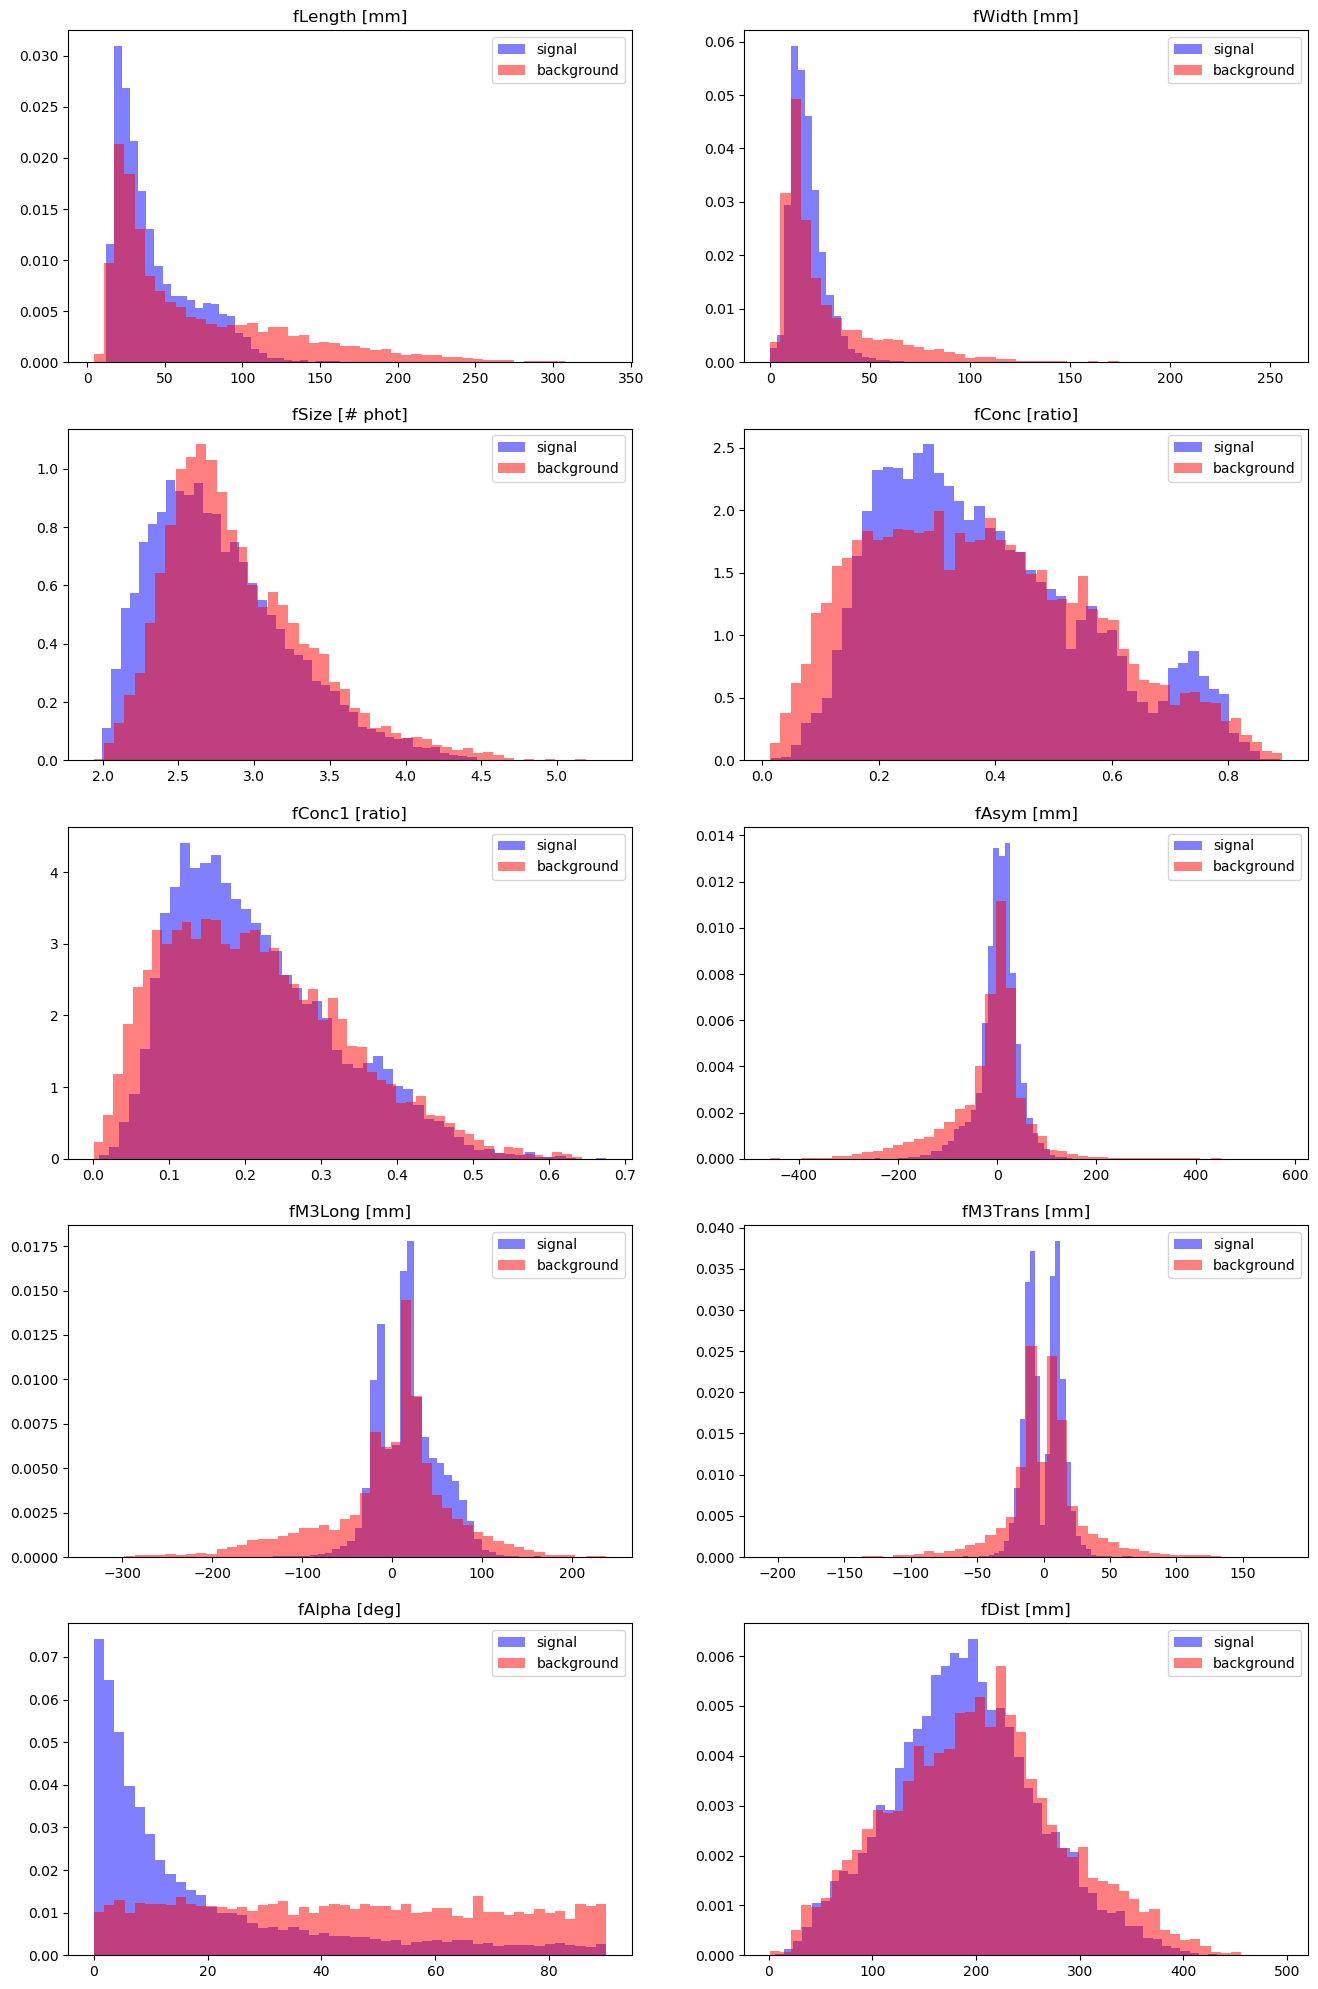

In [4]:
signals = pd.DataFrame(df[df['class']=='g'])
background = pd.DataFrame(df[df['class']=='h'])

unit_meas = ['mm', 'mm', '# phot', 'ratio', 'ratio', 'mm', 'mm', 'mm', 'deg', 'mm']

n_lines = len(features)//2
fig, ax = plt.subplots(nrows=n_lines, ncols=2, figsize=(16, 5*n_lines))
ax = ax.flatten()

for i in range(len(ax)):
    ax[i].hist(signals[features[i]],    bins=50, alpha=0.5, color='blue', label='signal',     density=True)
    ax[i].hist(background[features[i]], bins=50, alpha=0.5, color='red',  label='background', density=True)
    ax[i].set_title(features[i] + ' [' + unit_meas[i] + ']')
    ax[i].legend()

The purpose of these histogram is not to carry out a full analysis, but to get a first idea about the main feature's differences. The most interesting histogram is the one of the $fAlpha$ variable: here the *signal* and the *background* beahave completely differently, the first has a high peak at low angle values, while the second is distributed almost uniformly over the entire spectrum.
The other features, instead, do not show particular qualitative differences, and this lead to think about $fAlpha$ as the most important feature in discriminating *gammas* from *hadrons*. The only thing that we can say is that in general background data seems to be more dispersed than the others, that instead present higher and better defined peaks and also are restricted in a smaller region of the x-axis. An explanation of this behavior can be brought back maybe on some restrictions during their simulation.

### Study the correlations among the features of the datasets for signal and background events

*After considering each attribute independently, another fast analysis that can be done involves the correlations among different features of the dataset. A first, simple way according which we can do it is looking at their correlation matrix...*

In [5]:
corr_matrix = df[features].corr()
corr_matrix

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.770512,0.702454,-0.630999,-0.598145,-0.368556,-0.119747,0.013389,-0.008777,0.418466
fWidth,0.770512,1.000000,0.717517,-0.609779,-0.581141,-0.266961,-0.176234,0.039744,0.066061,0.336816
fSize,0.702454,0.717517,1.000000,-0.850850,-0.808835,-0.159863,0.095157,0.015455,-0.186675,0.437041
fConc,-0.630999,-0.609779,-0.850850,1.000000,0.976412,0.112272,-0.121899,-0.011294,0.235272,-0.328332
fConc1,-0.598145,-0.581141,-0.808835,0.976412,1.000000,0.100159,-0.118769,-0.010966,0.229799,-0.304625
fAsym,-0.368556,-0.266961,-0.159863,0.112272,0.100159,1.000000,0.274045,0.002553,-0.055689,-0.206730
fM3Long,-0.119747,-0.176234,0.095157,-0.121899,-0.118769,0.274045,1.000000,-0.017197,-0.186275,0.037025
fM3Trans,0.013389,0.039744,0.015455,-0.011294,-0.010966,0.002553,-0.017197,1.000000,0.004659,0.011427
fAlpha,-0.008777,0.066061,-0.186675,0.235272,0.229799,-0.055689,-0.186275,0.004659,1.000000,-0.220556
fDist,0.418466,0.336816,0.437041,-0.328332,-0.304625,-0.206730,0.037025,0.011427,-0.220556,1.000000


*and maybe plotting it!*

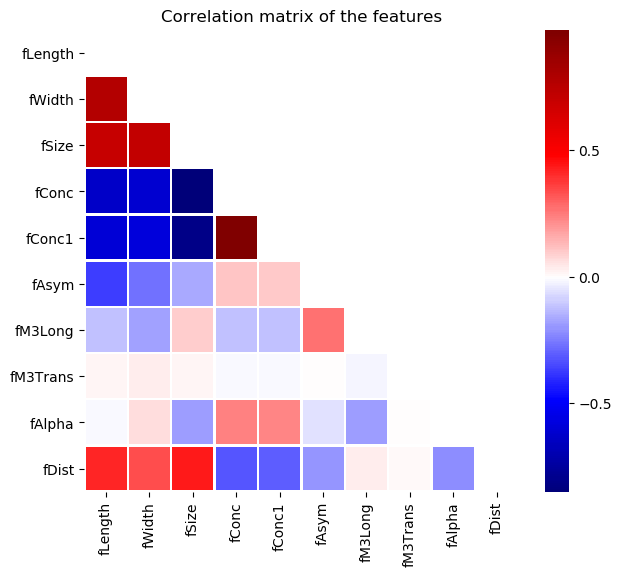

In [6]:
_, corr_ax = plt.subplots(figsize=(7,6))

# Since the correlation matrix is symmetric respect to the principal diagonal, we can just plot half of it
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, center=0, mask=mask, ax=corr_ax, linewidths=1,cmap='seismic')
corr_ax.set_title("Correlation matrix of the features")
sns.set(font_scale=2)


*From this initial check of the correlations, we can immediatly exclude some variables: the distance between the highest pixel to the center (fAsym), the third moments (fM3Long and fM3Trans) and the angle (fAlpha) are very poorly correlated with the other features and so we won't continue with them, in the sequent, and deeper, analysis.*

*Then, we think that the clearest way to plot these correlations is using a pairplot*

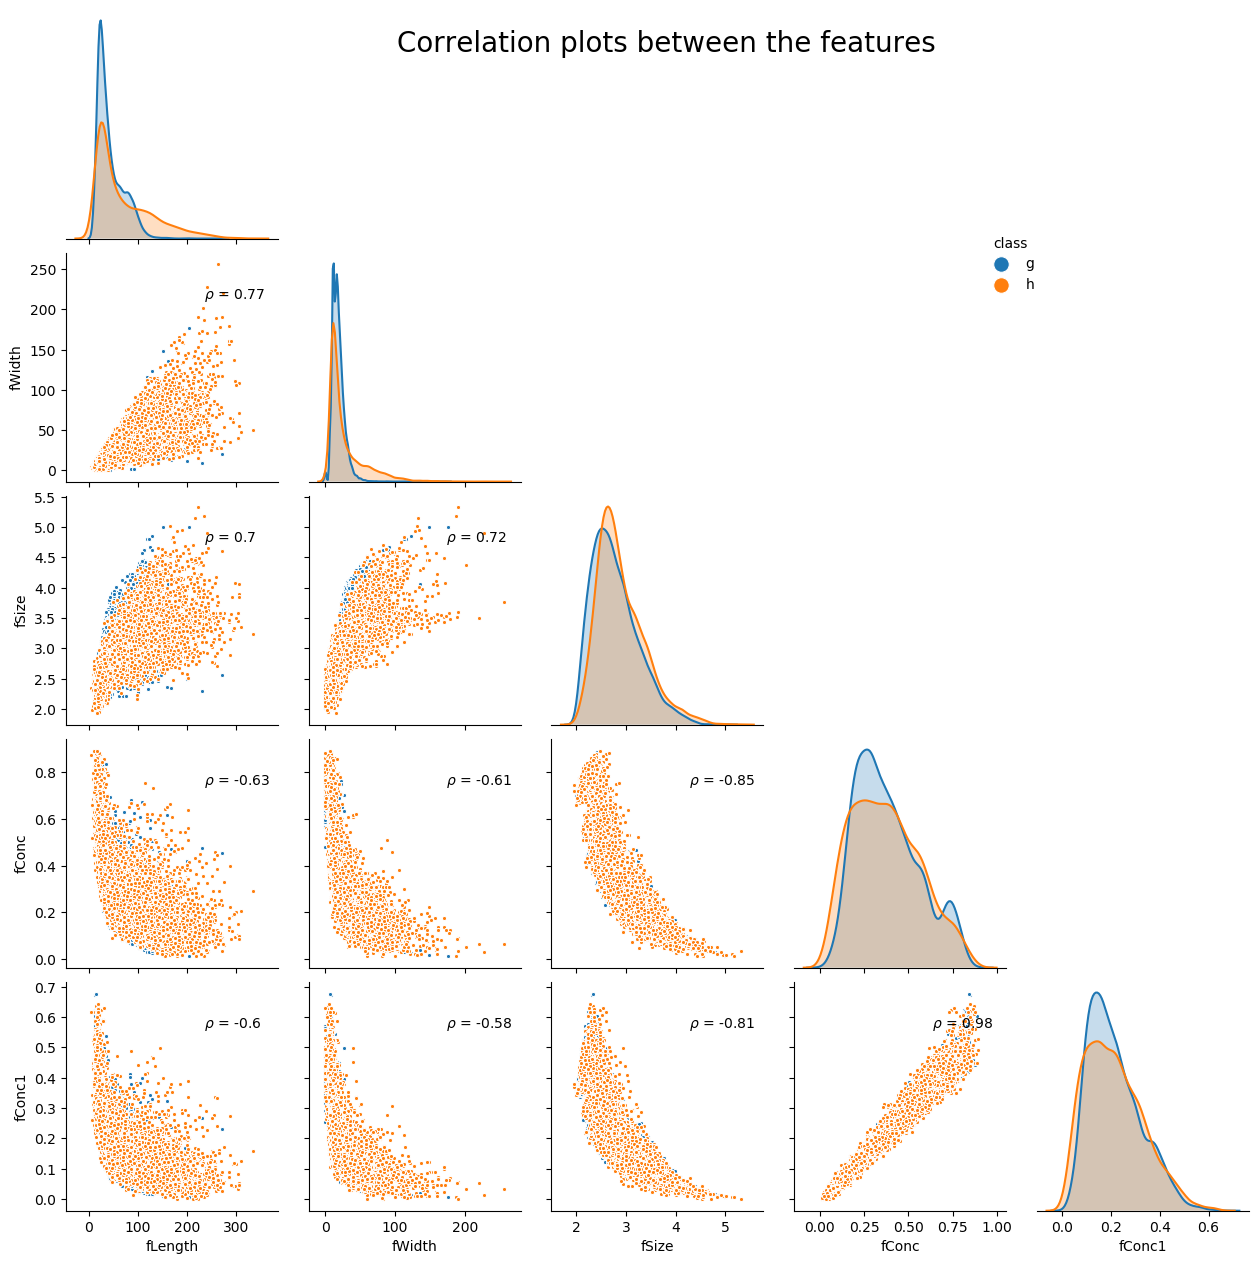

In [7]:
plt.style.use('default')
correlated_vars = ['fLength','fWidth','fSize','fConc','fConc1']
corr_coeffs = corr_matrix[correlated_vars].loc[correlated_vars]

pp = sns.pairplot(df, diag_kind='kde', hue='class', vars=correlated_vars, markers='.', corner=True)

for (i, j), ax in np.ndenumerate(pp.axes):
    if i>j: ax.text(s=r'$\rho$ = ' + str(round(corr_coeffs.iloc[i, j], 2)), x=0.65, y=0.8, transform=ax.transAxes)
        
#legend
pp._legend.set_bbox_to_anchor((0.8, 0.8))
for lh in pp._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [500] 
pp.fig.suptitle('Correlation plots between the features', size=20);

Some results are as expected: $fConc$ and $fConc1$, that are proportional by definition, are very strongly correlated, and they are anticorrelated with $FSize$. No other strong correlations/anticorrelations are present here.

### Compute the "mean-scaled-width" and the "mean-scale-length", i.e. rescale by means of their mean and standard deviation the "Width" and "Length" distributions. Compare them for signal and background events in the cases of little or a lot of light ("fSize").

*Here we have just to compute some new varibles that should improve the existing correlations between the Hillas parameters. <br>
These new variables were designed in order to provide a first way of comparing observed data (especially length and width of the ellipse) with the corresponding expectation values obtained from simulation. Since data we are dealing with are the simulated ones, we cannot make such comparison, but we can calculate anyway these interesting numbers.*

Two normalised parameters **Scaled Width (SW)** and **Scaled Length (SL)**:

$$
SW = \frac{w(q,p) - <w(q,p)>}{\sigma_w(q,p)} \qquad SL = \frac{l(q,p) - <l(q,p)>}{\sigma_l(q,p)}
$$

In [8]:
df["Scaled_Length"] = ( df["fLength"] - df["fLength"].mean() ) / df["fLength"].std()
df["Scaled_Width"] = ( df["fWidth"] - df["fWidth"].mean() ) / df["fWidth"].std()

df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,label,Scaled_Length,Scaled_Width
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g,1,-0.577211,-0.336795
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g,1,-0.510955,-0.570012
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g,1,2.568210,6.205695
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g,1,-0.694749,-0.687241
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g,1,0.516609,0.476371


These parameters have the noticeable advantage of being easily combined in stereoscopic observations in **Mean Scaled Width** and **Mean Scaled Length**:
   
$$
MSW = \frac{\sum SW}{\sqrt{N}} \qquad MSL = \frac{\sum SL}{\sqrt{N}}
$$

From simulations, one can show that the Mean Scaled Width and Mean Scaled Length are almost uncorrelated and can therefore be combined in a single variable **Mean Scaled Sum**:

$$
MSS = \frac{MSW + MSL}{\sqrt{2}}
$$

In [9]:
# Recompute the 2 dataframes to include also these last variables
signals = pd.DataFrame(df[df['class']=='g'])
background = pd.DataFrame(df[df['class']=='h'])

s_MSL = sum(signals["Scaled_Length"])/math.sqrt(len(signals["Scaled_Length"]))
s_MSW = sum(signals["Scaled_Width"])/math.sqrt(len(signals["Scaled_Width"]))
s_MSS = ( s_MSL + s_MSW ) / math.sqrt(2)

b_MSL = sum(background["Scaled_Length"])/math.sqrt(len(background["Scaled_Length"]))
b_MSW = sum(background["Scaled_Width"])/math.sqrt(len(background["Scaled_Width"]))
b_MSS = ( b_MSL + b_MSW ) / math.sqrt(2)

print("Features associated with pure signals:")
print("Mean Scale Length: ", s_MSL)
print("Mean Scale Width: ", s_MSW)
print("Mean Scale Sum: ", s_MSS)

print("\n")

print("Features associated with background:")
print("Mean Scale Length: ", b_MSL)
print("Mean Scale Width: ", b_MSW)
print("Mean Scale Sum: ", b_MSS)

Features associated with pure signals:
Mean Scale Length:  -25.152656475748948
Mean Scale Width:  -21.71995708060117
Mean Scale Sum:  -33.14394289763166


Features associated with background:
Mean Scale Length:  34.154858092519895
Mean Scale Width:  29.493586595071818
Mean Scale Sum:  45.006246850572985


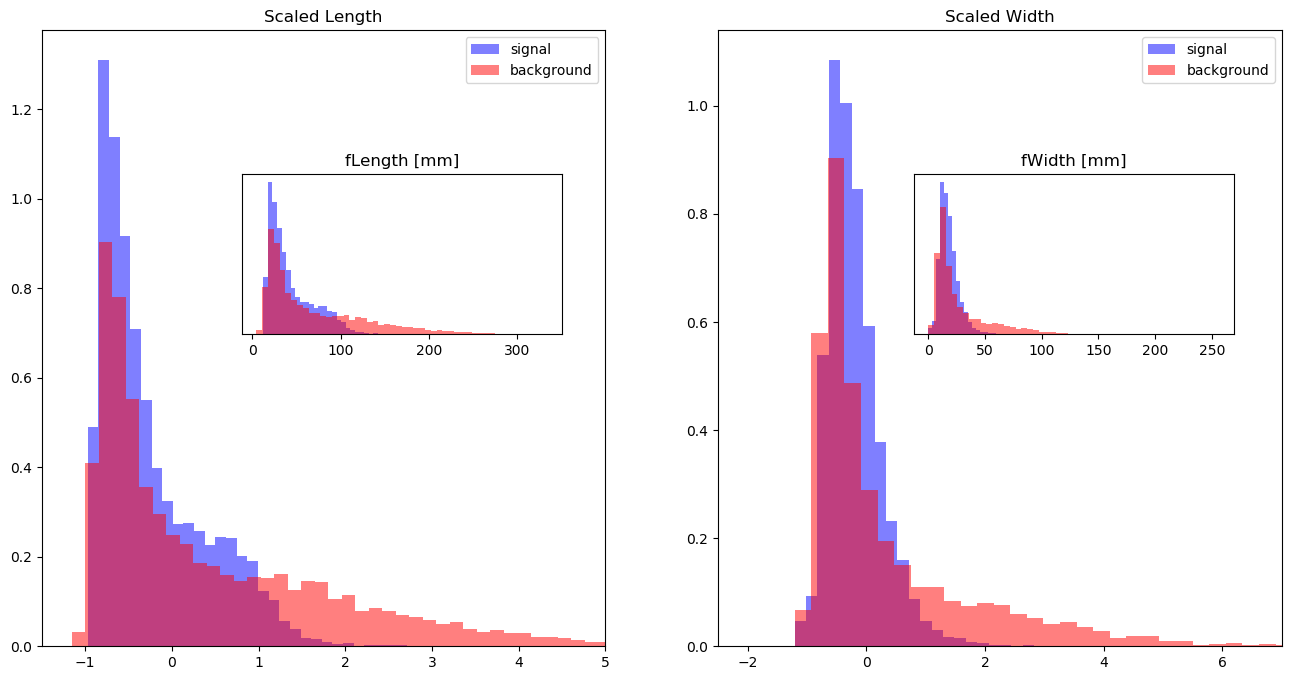

In [10]:
fig3, ax3 = plt.subplots(1, 2, figsize=(16,8))

ax3[0].hist(signals["Scaled_Length"],bins=50, alpha=0.5, color='blue', label='signal', density=True);
ax3[0].hist(background["Scaled_Length"],bins=50, alpha=0.5, color='red', label='background', density=True);
ax3[0].set_title("Scaled Length")
ax3[0].set_xlim(-1.5,5)
ax3[0].legend()

old_length = fig3.add_axes([0.25, 0.5, 0.2, 0.2])
old_length.hist(signals["fLength"],    bins=50, alpha=0.5, color='blue', label='signal',     density=True)
old_length.hist(background["fLength"], bins=50, alpha=0.5, color='red',  label='background', density=True)
old_length.set_title("fLength [mm]")
old_length.set_yticks([])

ax3[1].hist(signals["Scaled_Width"],bins=50, alpha=0.5, color='blue', label='signal', density=True);
ax3[1].hist(background["Scaled_Width"],bins=50, alpha=0.5, color='red', label='background', density=True);
ax3[1].set_title("Scaled Width")
ax3[1].set_xlim(-2.5,7)
ax3[1].legend()

old_width = fig3.add_axes([0.67,0.5,0.2,0.2])
old_width.hist(signals["fWidth"],    bins=50, alpha=0.5, color='blue', label='signal',     density=True)
old_width.hist(background["fWidth"], bins=50, alpha=0.5, color='red',  label='background', density=True)
old_width.set_title("fWidth [mm]")
old_width.set_yticks([]);

*Finally, we have to compare the results in the case of little or a lot of light, i.e. when the parameter "fSize" is big or not. We will do it simply selecting subset of data according to a certain threshold, and then plotting them in an histogram.*

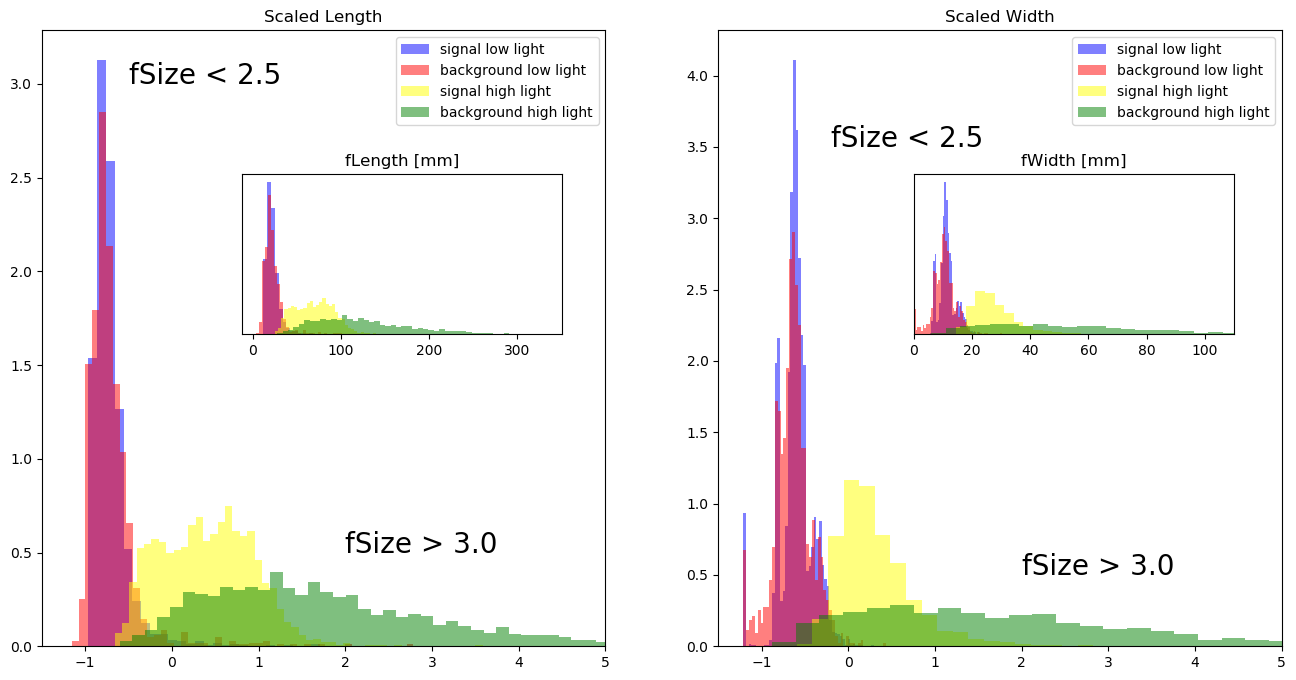

In [11]:
threshold_high = 3.0
threshold_low  = 2.5

low_light_s = signals.loc[signals["fSize"] < threshold_low, ["fLength", "fWidth", "Scaled_Width", "Scaled_Length"]]
low_light_b = background.loc[background["fSize"] < threshold_low, ["fLength", "fWidth", "Scaled_Width", "Scaled_Length"]]

high_light_s = signals.loc[signals["fSize"] > threshold_high, ["fLength", "fWidth", "Scaled_Width", "Scaled_Length"]]
high_light_b = background.loc[background["fSize"] > threshold_high, ["fLength", "fWidth", "Scaled_Width", "Scaled_Length"]]


fig4, ax4 = plt.subplots(1, 2, figsize=(16,8))

ax4[0].hist(low_light_s["Scaled_Length"],  bins=50, alpha=0.5, color='blue',   label='signal low light',      density=True)
ax4[0].hist(low_light_b["Scaled_Length"],  bins=50, alpha=0.5, color='red',    label='background low light',  density=True)
ax4[0].hist(high_light_s["Scaled_Length"], bins=50, alpha=0.5, color='yellow', label='signal high light',     density=True)
ax4[0].hist(high_light_b["Scaled_Length"], bins=50, alpha=0.5, color='green',  label='background high light', density=True)
ax4[0].set_title("Scaled Length")
ax4[0].set_xlim(-1.5, 5)
ax4[0].legend()
ax4[0].annotate("fSize < " + str(threshold_low), xy = (-0.5, 3), size=20)
ax4[0].annotate("fSize > " + str(threshold_high), xy = (2, 0.5), size=20)


old_length_lowhigh = fig4.add_axes([0.25, 0.5, 0.2, 0.2])
old_length_lowhigh.hist(low_light_s["fLength"], bins=50, alpha=0.5, color='blue', density=True)
old_length_lowhigh.hist(low_light_b["fLength"], bins=50, alpha=0.5, color='red',  density=True)
old_length_lowhigh.hist(high_light_s["fLength"], bins=50, alpha=0.5, color='yellow', density=True)
old_length_lowhigh.hist(high_light_b["fLength"], bins=50, alpha=0.5, color='green',  density=True)
old_length_lowhigh.set_title("fLength [mm]")
old_length_lowhigh.set_yticks([])



ax4[1].hist(low_light_s["Scaled_Width"], bins=50, alpha=0.5, color='blue',   label='signal low light',      density=True)
ax4[1].hist(low_light_b["Scaled_Width"], bins=50, alpha=0.5, color='red',    label='background low light',  density=True)
ax4[1].hist(high_light_s["Scaled_Width"],bins=50, alpha=0.5, color='yellow', label='signal high light',     density=True)
ax4[1].hist(high_light_b["Scaled_Width"],bins=50, alpha=0.5, color='green',  label='background high light', density=True)
ax4[1].set_title("Scaled Width")
ax4[1].set_xlim(-1.5,5)
ax4[1].legend()
ax4[1].annotate("fSize < " + str(threshold_low), xy = (-0.2, 3.5), size=20)
ax4[1].annotate("fSize > " + str(threshold_high), xy = (2, 0.5), size=20)

old_width_lowhigh = fig4.add_axes([0.67,0.5,0.2,0.2])
old_width_lowhigh.hist(low_light_s["fWidth"],  bins=50, alpha=0.5, color='blue', density=True)
old_width_lowhigh.hist(low_light_b["fWidth"],  bins=50, alpha=0.5, color='red',  density=True)
old_width_lowhigh.hist(high_light_s["fWidth"], bins=50, alpha=0.5, color='yellow', density=True)
old_width_lowhigh.hist(high_light_b["fWidth"], bins=50, alpha=0.5, color='green',  density=True)
old_width_lowhigh.set_xlim(0,110)
old_width_lowhigh.set_title("fWidth [mm]")
old_width_lowhigh.set_yticks([]);

These histograms are very interesting: with few light gamma's scaled length and width are similar with background's scaled length and width. With high light, instead, the histograms show differences in both cases: signal has still a peaked behaviour, while the background has flattened. A similar behavior holds also for the original parameters fLength and fWidth, so we don't think that this step will provide so much additional information to us, especially becuase this is nothing but a renormalization of the length and the width that will be anyway computed before applying a multivariate method in the next steps. Another proof of what we are saying can be found when performing the PCA.

### Perform a Principal Component Analysis on that dataset for the signal and the background events

*Before performing directly a Principal Component Analysis over our dataset, it is better to give a first look at the covariance matrix with the corresponding eigenvectors and eigenvalues. This choice is done especially because we are working with several features (precisely, in a 10-dimensional feature space) and so it is fine to have an idea a priori of which and how many components dominate over the others.*

In [12]:
# Standardize data
std_data = StandardScaler().fit_transform(df.drop(['class', 'label','Scaled_Length','Scaled_Width'], axis=1)).T # normalizing the features

# Eigenvalues
eigA, eigV = la.eig(np.cov(std_data))
eigA = np.real(eigA)
print(sorted(eigA,reverse=True))

[4.224212992629756, 1.5752707234692058, 1.0118585196390188, 0.9940649615760564, 0.7420584088376563, 0.6501206481963044, 0.4075600256409166, 0.22037401335211967, 0.1547615179961863, 0.020243978662257987]


*The eigenvalues are already ordered by magnitude, and we can notice that the first ones are a couple of order of magnitude larger that the last, and so this may represent a feature that can be easily dropped without losing basically any information. A deeper analysis on the number of principal components to keep can be performed by computing the total variability, i.e. the fraction of information still avaiable reducing the number of components, for each k < 10.*

*The PCA will be performed using a proper function imported from sklearn, that make use of the Singular Value Decomposition (SVD) of the data to project them to a lower dimensional space.*

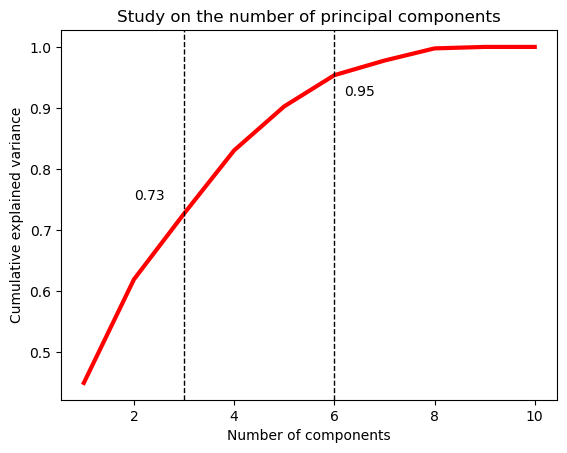

In [13]:
# Here we just make a generic study in order to understand which is the best number of components

pca = PCA().fit(std_data)
cev = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, std_data.shape[0]+1), cev, color='red', lw=3)
plt.axvline(3, ls='--', c='black', lw=1)
plt.annotate(round(cev[2], 2), xy=(2,0.75))
plt.axvline(6, ls='--', c='black', lw=1)
plt.annotate(round(cev[5], 2), xy=(6.2,0.92))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Study on the number of principal components');

*Now that we can see easily how much information we lose for any number of principal components we select, we make the following choice: we will perform two different PCA, one more "safe" with 6 principal components (to preserve the 94% of the information) and one less safe but also less computationally expensive with 3 principal components (73% of the total variance) that also allow for a visual representation of the data. In this way, we will improve the performances of the classifiers in the next step of the analysis and we will also provide a term of comparison between the two dimensionality reduced datasets.* 

In [18]:
# Now let's run the PCA

# Case 1: 6 principal components
pca6 = PCA(n_components=6).fit_transform(std_data.T)
df_6 = pd.DataFrame(data = pca6, columns = ['PCA-1', 'PCA-2', 'PCA-3', 'PCA-4', 'PCA-5', 'PCA-6'])
df_6['label'] = df['label']

# Case 2: 3 principal components
pca3 = PCA(n_components=3).fit_transform(std_data.T)
df_3 = pd.DataFrame(data = pca3, columns = ['PCA-1', 'PCA-2', 'PCA-3'])
df_3['label'] = df['label']

df_3.head(5)

,PCA-1,PCA-2,PCA-3,label
0,-1.216289,-0.224876,1.150382,1
1,-1.851695,-0.324141,-0.829324,1
2,8.562499,2.259830,3.298342,1
3,-2.666758,0.329500,-0.266757,1
4,1.725392,-0.769255,-1.032807,1


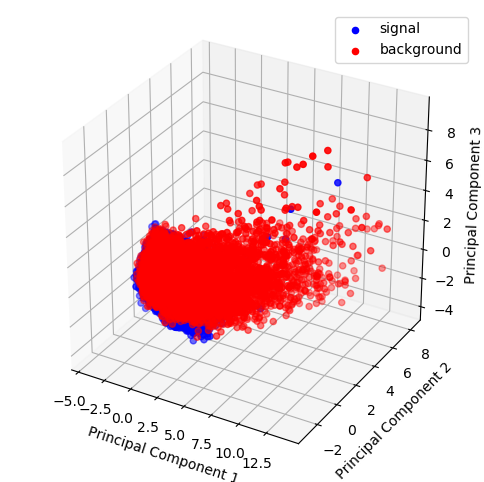

In [22]:
#%matplotlib qt

ax_sct = plt.figure(figsize=(6,6)).add_subplot(111, projection='3d')

signal_pca3 = df_3[df_3["label"]==1]
background_pca3 = df_3[df_3["label"]==0]

ax_sct.scatter(signal_pca3['PCA-1'], signal_pca3['PCA-2'], signal_pca3['PCA-3'], color="blue", label="signal")
ax_sct.scatter(background_pca3['PCA-1'], background_pca3['PCA-2'], background_pca3['PCA-3'], color="red", label="background")
ax_sct.set_xlabel("Principal Component 1")
ax_sct.set_ylabel("Principal Component 2")
ax_sct.set_zlabel("Principal Component 3")
ax_sct.legend();

*Let's examine also the projections.*

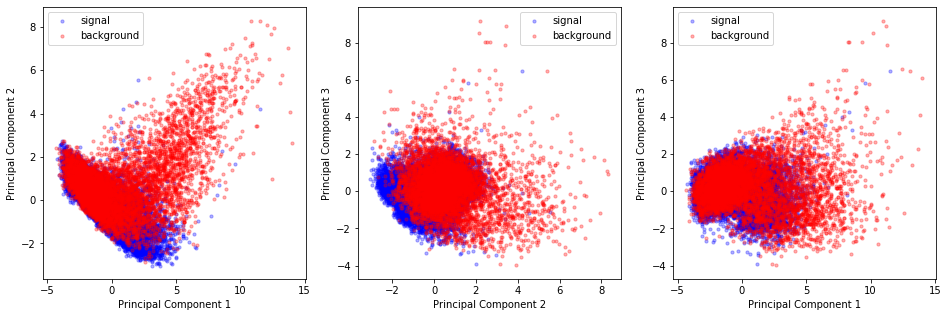

In [23]:
%matplotlib inline

_, ax_proj = plt.subplots(1, 3, figsize=(16,5))
ax_proj[0].scatter(signal_pca3['PCA-1'], signal_pca3['PCA-2'], color="blue", label="signal", alpha=0.3, s=10)
ax_proj[0].scatter(background_pca3['PCA-1'], background_pca3['PCA-2'], color="red", label="background", alpha=0.3, s=10)
ax_proj[0].set_xlabel("Principal Component 1")
ax_proj[0].set_ylabel("Principal Component 2")
ax_proj[0].legend()

ax_proj[1].scatter(signal_pca3['PCA-2'], signal_pca3['PCA-3'], color="blue", label="signal", alpha=0.3, s=10)
ax_proj[1].scatter(background_pca3['PCA-2'], background_pca3['PCA-3'], color="red", label="background", alpha=0.3, s=10)
ax_proj[1].set_xlabel("Principal Component 2")
ax_proj[1].set_ylabel("Principal Component 3")
ax_proj[1].legend()

ax_proj[2].scatter(signal_pca3['PCA-1'], signal_pca3['PCA-3'], color="blue", label="signal", alpha=0.3, s=10)
ax_proj[2].scatter(background_pca3['PCA-1'], background_pca3['PCA-3'], color="red", label="background", alpha=0.3, s=10)
ax_proj[2].set_xlabel("Principal Component 1")
ax_proj[2].set_ylabel("Principal Component 3")
ax_proj[2].legend();

From these last plots it can be seen that the background is more spread out as compared to the signal. This is most evident in the first panel.

## Another technique of dimensionality reduction: t-SNE

*t-SNE is a relatively new dimensionality reduction technique and differs from PCA by preserving only small pairwise distances or local similarities whereas PCA preserves large pairwise distances to maximize variance.*

In [24]:
tsne3 = TSNE(n_components=3,perplexity=50).fit_transform(std_data.T)

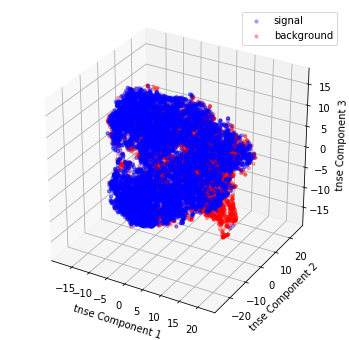

In [25]:
df_tsne3 = pd.DataFrame(data = tsne3, columns = ['tsne-1', 'tsne-2','tsne-3'])
df_tsne3['label'] = df['label']
signal_tsne3 = df_tsne3[df_tsne3["label"]==1]
background_tsne3 = df_tsne3[df_tsne3["label"]==0]

ax_sct = plt.figure(figsize=(6,6)).add_subplot(111, projection='3d')
ax_sct.scatter(signal_tsne3['tsne-1'], signal_tsne3['tsne-2'], signal_tsne3['tsne-3'], color="blue", label="signal", alpha=0.3, s=10)
ax_sct.scatter(background_tsne3['tsne-1'], background_tsne3['tsne-2'],background_tsne3['tsne-3'], color="red", label="background", alpha=0.3, s=10)

ax_sct.set_xlabel("tnse Component 1")
ax_sct.set_ylabel("tnse Component 2")
ax_sct.set_zlabel("tnse Component 3")
ax_sct.legend()

In [26]:
tsne2 = TSNE(n_components=2,perplexity=50).fit_transform(std_data.T)

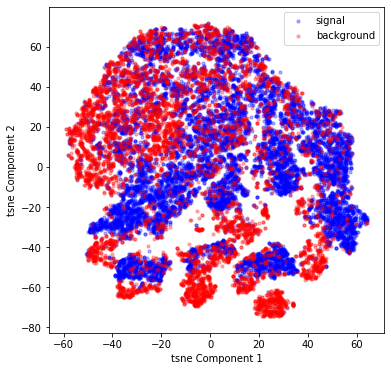

In [27]:
df_tsne2 = pd.DataFrame(data = tsne2, columns = ['tsne-1', 'tsne-2'])
df_tsne2['label'] = df['label']
signal_tsne2 = df_tsne2[df_tsne2["label"]==1]
background_tsne2 = df_tsne2[df_tsne2["label"]==0]
fig=plt.figure(figsize=(6,6))
plt.scatter(signal_tsne2['tsne-1'], signal_tsne2['tsne-2'], color="blue", label="signal", alpha=0.3, s=10)
plt.scatter(background_tsne2['tsne-1'], background_tsne2['tsne-2'],color="red", label="background", alpha=0.3, s=10)

plt.xlabel("tsne Component 1")
plt.ylabel("tsne Component 2")
plt.legend()

## Perform a multivariate analysis with the technique you prefer and evaluate its performance (e.g. in terms of Area Under the (ROC) Curve)

The purpose of this part is to build some machine learning architectures with the purpose of classifying our data. The comparison between the models will be done through the **ROC curve**. Let's see how does this work: the architecture to be trained, given a sample, must give as output the **probability that that the sample is a signal** (classified as 1). At this point one can fix a **custom threshold probability**, above which data are classified as signals, and under which data are classified as background. For the comparison, we must define the True Positive Rate and the False Positive Rate:

$$
tpr = \frac{\# True Positive}{\#True Positive + \#False Negative}
$$

$$
fpr = \frac{\# False Positive}{\#False Positive + \#True Negative}
$$

that will be analyzed in a graphic. The reason of this analysis is that classifying a background as a signal (i.e., a False Positive) is much worse than doing the inverse. Therefore **our models will be compared looking at the $tpr$ at some values of interest of the $fpr$**.
Lower values of the $fpr$ (and of the $tpr$ also) are achieved raising the threshold: higher the threshold, harder to be classified as an event, less the False Positives but the True Positives as well.

To make this clear: 
+ Smaller values on the x-axis of the plot indicate both higher False negatives and True negatives
+ Larger values on the y-axis of the plot indicate both higher true positives and lower false positives.

Unfortunately, choosing custom values of the $fpr$ will not be possible, since these are discrete values coming from the choice of the threshold: we will therefore look at the $tpr$ at values of the $fpr$ as close as possible to the assigned ones.

Finally, the models can be evaluated also looking at the AUC score, i.e. the area under the ROC curve, that can be used as a summary of the model performance and should be as close as possible to one.

In [26]:
def transform_split(X,Y):
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    Y = Y[permutation]

    # train-test splitting
    train_size = 0.8
    train_len = int(train_size * X.shape[0])

    X_train, X_test = X[:train_len], X[train_len:]
    Y_train, Y_test = Y[:train_len], Y[train_len:]

    # scaling data
    transformer = MinMaxScaler(feature_range=(-1, 1), copy=True)
    transformer.fit(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)
    
    return X_train, Y_train, X_test, Y_test

In [24]:
class ROC_Analysis():
    ''' This class holds all the function involving calculations and plots about the ROC curve, such that 
    to study different models you just need to create more instances of this object. '''
    
    def __init__(self, name, true_labels, predictions, fpr_th=[0.01, 0.02, 0.05, 0.1, 0.2], model=None):
        
        self.name = name
        self.true_labels = true_labels
        self.predictions = predictions
        self.fpr_th = fpr_th
        
        self.fpr = None
        self.tpr = None
        self.thresholds = None
        self.AUC_score = None
        
        self.model = model
        
        
    def Compute_ROC_Curve(self):
        ''' This function compute the values necessary to study the ROC curve and need to be
        executed called plotting it. '''
        
        self.fpr, self.tpr, self.thresholds = roc_curve(self.true_labels, self.predictions)
        self.AUC_score = roc_auc_score(self.true_labels, self.predictions)
        
        
    def Find_Closest_Parameters(self):
        ''' Return the closest fpr available values to the requested ones '''
        
        s = len(self.fpr_th)
        closest_fpr, closest_tpr, indexes = np.zeros(s), np.zeros(s), np.zeros(s, dtype=int)

        for ii in range(s):       
            indexes[ii] = np.searchsorted(self.fpr, self.fpr_th[ii])
        
        closest_fpr = self.fpr[indexes]
        closest_tpr = self.tpr[indexes]
        closest_th  = self.thresholds[indexes]
        
        return (closest_fpr, closest_tpr, closest_th)
    
        
    def Plot_ROC_Curve(self, axes=None):
        
        if self.AUC_score == None: self.Compute_ROC_Curve()
        
        if axes == None: fig, axes = plt.subplots(figsize=(7,6))
        axes.plot(self.fpr, self.tpr, color="orange", label=self.name+"_ROC")
        axes.plot([0, 1], [0, 1], color="darkblue", linestyle='--', label="Random Guess")
        
        cl_fpr, cl_tpr, cl_th = self.Find_Closest_Parameters()
        axes.scatter(cl_fpr, cl_tpr, color="red", label="Relevant pts, with thr. values")
        for ii in range(len(self.fpr_th)): 
            plt.annotate('%.3f' % cl_th[ii], (cl_fpr[ii], cl_tpr[ii]), 
                         xytext=(cl_fpr[ii]+0.03,cl_tpr[ii]-0.02),fontsize=11)
        
        txt_roc_auc = "roc_auc = %.3f" % self.AUC_score
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        axes.text(0.6, 0.4, txt_roc_auc, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=props)

        axes.set_xlabel("False Positive Rate")
        axes.set_ylabel("True Positive Rate")
        axes.set_title("ROC Curve of the " + self.name)
        axes.grid()
        axes.legend()
        
    
    def Display_Results(self):
        ''' Create a table to summarize the closes values of fpr and tpr to the thresholds given '''
        
        if self.AUC_score == None: self.Compute_ROC_Curve()        
        cl_fpr, cl_tpr, cl_th = self.Find_Closest_Parameters()
        
        inf_df = pd.DataFrame(np.vstack((np.array(self.fpr_th), cl_fpr, cl_tpr, cl_th)).round(4))
        inf_df.index = ['values', 'closest_fpr','tpr','threshold']
        inf_df.columns = ['']*5
        
        return inf_df
            

In [42]:
def Retrieve_Best_Model(analysis_objects, verbose=False):
    ''' This function is supposed to receive in input a dictionary of ROC_Analysis objects, and compare them
    using as discriminator the roc_auc value, i.e. the area under their roc curve, and plot them. '''
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Setup comparison plot
    ax[0].plot([0, 1], [0, 1], color="darkblue", linestyle='--', label="Random Guess")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("Comparison of different ROC Curves")
    
    # Variables defined in order to find the maximum of the roc auc values
    best_model = None
    max_auc = 0
    auc_values = []
        
    for key in analysis_objects:
        analysis_objects[key].Compute_ROC_Curve()
        ax[0].plot(analysis_objects[key].fpr, analysis_objects[key].tpr)
        roc_auc = analysis_objects[key].AUC_score
        auc_values.append(roc_auc)
        if roc_auc > max_auc:
            best_model = analysis_objects[key]
            max_auc = roc_auc
        
        if verbose:
            print(key, "ROC AUC = ", roc_auc)
            
    
    # Setup best model plot
    best_model.Plot_ROC_Curve(axes=ax[1])
    
    
    # Add an histogram representing the frequencies of the roc_auc values
    hist_ax = fig.add_axes([0.25, 0.2, 0.2, 0.2])
    hist_ax.hist(auc_values, bins=len(analysis_objects))
    hist_ax.set_yticks([])

    return best_model

In [27]:
# defining features matrix X and labels vector y
X = np.array(df.iloc[:,0:10])
Y = np.array(df.iloc[:,11])
X_train, Y_train, X_test, Y_test = transform_split(X,Y)

## Neural Network

The first multivariate analysis technique we are going to analyze is a **Neural network classifier**: this is a simple machine learning architrecture, and it is interesting to see whether it is able to perform the required classification task. An hyperparameter optimization is made via Grid Search, using as criterion the area under the ROC curve.

In [48]:
def create_MLP(activation,solver,hidden_layer_sizes,learning_rate_init):
    ''' Here we give the parameters in input to our Multi-Layer-Perceptron '''
    
    return MLPClassifier( activation=activation, 
                          hidden_layer_sizes=hidden_layer_sizes, 
                          solver=solver,
                          learning_rate_init=learning_rate_init, 
                          shuffle=True, 
                          max_iter=1000)

# Initialization of MLP classifier
params_MLP = {"activation"         :  ["logistic", "tanh", "relu"],
              "solver"             :  ["sgd", "adam"],
              "hidden_layer_sizes" :  [(10,10,10),(20,20),(50), (80, 40, 20, 10)],
              "learning_rate_init" :  [0.1,0.01,0.001]}

In [49]:
AnalysisObjects_MLP = {}

counter = 1
for params in tqdm(list(ParameterGrid(params_MLP))):
    mlp = create_MLP(**params)
    mlp.fit(X_train, Y_train)
    pred = mlp.predict_proba(X_test)[:, 1] 
    AnalysisObjects_MLP['MLP_'+str(counter)] = ROC_Analysis(name='MLP_'+str(counter), 
                                                            true_labels=Y_test, predictions=pred, model=mlp)
    counter+=1

100%|██████████| 72/72 [43:52<00:00, 36.57s/it] 


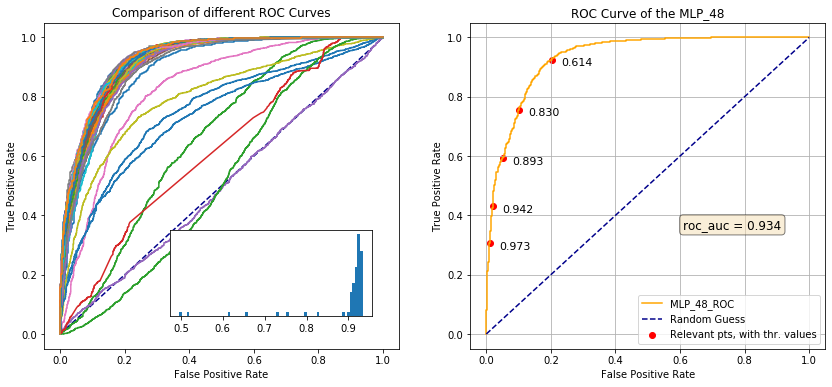

In [50]:
best_MLP = Retrieve_Best_Model(AnalysisObjects_MLP, verbose=False)

In [51]:
best_MLP.Display_Results()

,,,,,
values,0.0100,0.0200,0.0500,0.1000,0.2000
closest_fpr,0.0102,0.0203,0.0508,0.1009,0.2025
tpr,0.3067,0.4312,0.5919,0.7560,0.9254
threshold,0.9731,0.9416,0.8933,0.8305,0.6140


In [52]:
print('Best model parameters: ')
best_MLP.model

Best model parameters: 


MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40, 20, 10),
              max_iter=1000)

## Random Forest

Another multivariate analysis technique that can be analyzed is the **Random Forest**, that is the adviced method by many of the references. A random forest in an ensemble method: it is a collection of predictors (called trees) that vote on the output, and the overall result is the prediction of the whole Random Forest. Once again we make a hyperparameter optimization via Grid Search.

In [ ]:
def create_RF(bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators):
    ''' Here we give the parameters in input to our Multi-Layer-Perceptron '''
    
    return RandomForestClassifier( bootstrap=bootstrap, 
                                   max_features=max_features, 
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split, 
                                   n_estimators=n_estimators)

# Initialization of MLP classifier
params_RF = {'bootstrap': [True, False],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [20, 40, 60, 80]}

In [40]:
AnalysisObjects_RF = {}

counter = 1
for params in tqdm(list(ParameterGrid(params_RF))):
    rf = create_RF(**params)
    rf.fit(X_train, Y_train)
    pred = rf.predict_proba(X_test)[:, 1] 
    AnalysisObjects_RF['RF_'+str(counter)] = ROC_Analysis(name='RF_'+str(counter), 
                                                            true_labels=Y_test, predictions=pred, model=rf)
    counter+=1

100%|██████████| 144/144 [09:26<00:00,  3.94s/it]


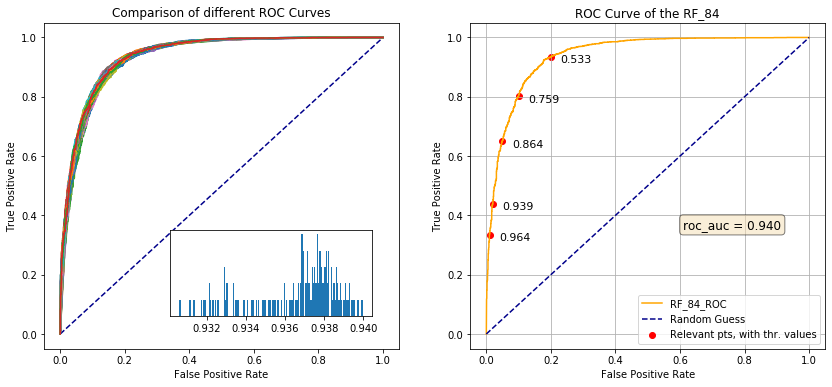

In [43]:
best_RF = Retrieve_Best_Model(AnalysisObjects_RF, verbose=False)

In [44]:
best_RF.Display_Results()

,,,,,
values,0.0100,0.0200,0.0500,0.1000,0.2000
closest_fpr,0.0102,0.0203,0.0501,0.1001,0.2003
tpr,0.3347,0.4394,0.6505,0.8017,0.9345
threshold,0.9639,0.9391,0.8639,0.7585,0.5329


In [86]:
print('Best model parameters: ')
best_RF.model

Best model parameters: 


RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=80)

As can be seen already in general the usage of a random forest seems to provide better and more stable results than using a neural network, especially because for the latter there are several combination of hyperparameters that results in very bad models, while here the results are quite similar (and nice) for each of the random forests analized.

### Comparison

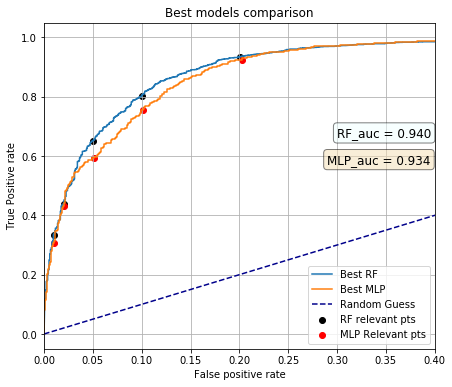

In [53]:
plt.figure(figsize=(7,6))
plt.xlim(right=0.4)
plt.plot(best_RF.fpr,  best_RF.tpr,  label='Best RF')
plt.plot(best_MLP.fpr, best_MLP.tpr, label='Best MLP')
plt.plot([0, 1], [0, 1], color="darkblue", linestyle='--', label="Random Guess")

cl_fpr, cl_tpr, cl_th = best_RF.Find_Closest_Parameters()
plt.scatter(cl_fpr, cl_tpr, color="black", label="RF relevant pts")

cl_fpr, cl_tpr, cl_th = best_MLP.Find_Closest_Parameters()
plt.scatter(cl_fpr, cl_tpr, color="red", label="MLP Relevant pts")

props = dict(boxstyle="round", facecolor="azure", alpha=0.5)
txt_roc_auc = "RF_auc = %.3f" % best_RF.AUC_score
plt.text(0.3, 0.7, txt_roc_auc, fontsize=12, verticalalignment='top', bbox=props)

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
txt_roc_auc = "MLP_auc = %.3f" % best_MLP.AUC_score
plt.text(0.29, 0.61, txt_roc_auc, fontsize=12, verticalalignment='top', bbox=props)

plt.title('Best models comparison')
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.grid()
plt.legend()
plt.show()

As it is possibile to see, the two best models are quite similar, but interestingly the best MLP performs better for the two lowest thresholds, while RF performs better for the other higher ones. It seems however that the Random Forest is more stable: as it can be seen above, the performance is always good even changing many hyperparameters.

To check the effective performances on our test set we can use a confusion matrix.

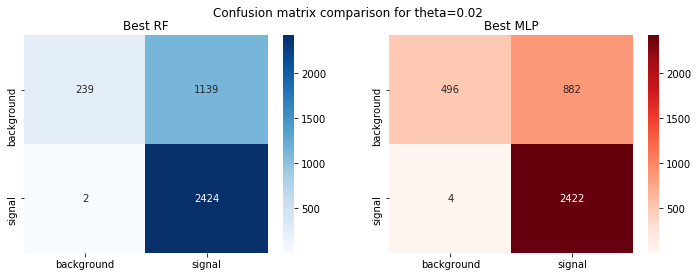

In [54]:
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

pred_binary = np.where(best_RF.predictions < 0.02,0, 1)
cm = confusion_matrix(Y_test, pred_binary)
labels=['background','signal']
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", ax=axs[0]);
axs[0].set_title('Best RF')

pred_binary = np.where(best_MLP.predictions < 0.02,0, 1)
cm = confusion_matrix(Y_test, pred_binary)
labels=['background','signal']
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Reds",ax=axs[1])
axs[1].set_title('Best MLP')

fig.suptitle('Confusion matrix comparison for theta=0.02')
plt.show()

### Feature Importance

This is a tecnique that gives an estimate of the importance of each features. The importance of each feature is calculated as the difference of performance between the standard performance and the performance obtained by randomly reshuffling the instances of that feature.

In [55]:
best_MLP.model.fit(X_train, Y_train)
best_RF.model.fit(X_train, Y_train)

imp1 = permutation_importance(best_RF.model, X_train,Y_train)
imp2 = permutation_importance(best_MLP.model,X_train,Y_train)

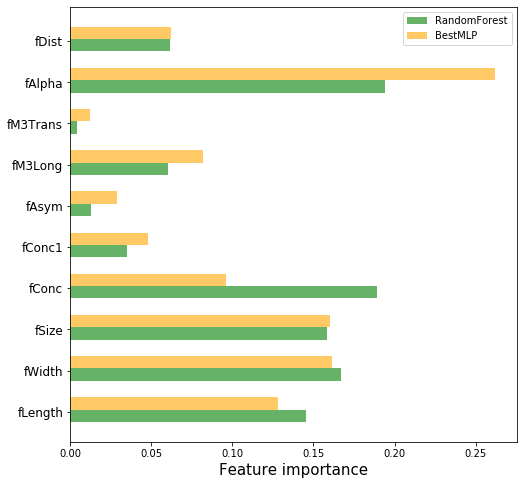

In [56]:
index = list(df.columns)
plt.figure(figsize=(8,8))
plt.barh(np.arange(10)+0.3,imp2['importances_mean'], color='green',  label="RandomForest", alpha=0.6, height=0.3)
plt.barh(np.arange(10)+0.6,imp1['importances_mean'], color='orange', label="BestMLP",      alpha=0.6, height=0.3)
plt.yticks(np.arange(10)+0.4,index,rotation=0,fontsize=12)
plt.xlabel('Feature importance',fontsize=15)
plt.legend()
plt.show()

The above graph shows a comparison between feature importances' of the best random forest model and of the best neural network model found by the grid search. Some columns are similar, and it is not surprising the big importance of $fAlpha$.

### Random forest with modified features

Here we decide to exploit what seen in the feature analysis, and to train the model with the $Length$ and the $Width$ features for high values of $fSize$ only.

In [57]:
df_high = df[df['fSize']>3.0]
print('Samples of the filtered dataset: ', len(df_high))

Samples of the filtered dataset:  5807


In [58]:
# defining features matrix X and labels vector y
X_high = np.array(df_high.iloc[:,0:10])
Y_high = np.array(df_high.iloc[:,11])
X_train_high, Y_train_high, X_test_high, Y_test_high = transform_split(X_high, Y_high)

In [59]:
#define and train model1: random forest
frandom_forest = best_RF.model.fit(X_train_high, Y_train_high)
frandom_forest

RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=80)

In [60]:
# save predicted probabilities
fpred_randomforest = frandom_forest.predict_proba(X_test_high)[:, 1]   #we keep the probs for the positive class only
fpred_randomforest 

array([0.0025    , 0.99166667, 0.95873016, ..., 0.07570933, 1.        ,
       0.995     ])

Accuracy:  0.946
                                                   
values       0.0100  0.0200  0.0500  0.1000  0.2000
closest_fpr  0.0138  0.0206  0.0505  0.1032  0.2064
tpr          0.7493  0.7782  0.9242  0.9614  0.9890
threshold    0.9222  0.9013  0.7006  0.4054  0.1751


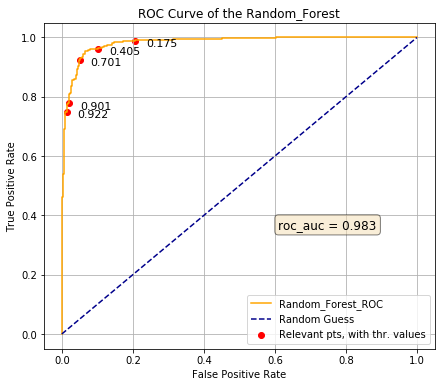

In [61]:
frf_rocan = ROC_Analysis(name="Random_Forest", true_labels=Y_test_high, predictions=fpred_randomforest)
frf_rocan.Plot_ROC_Curve()
print('Accuracy:  %.3f' % frandom_forest.score(X_test_high, Y_test_high))
print(frf_rocan.Display_Results())

The result is insanely good. This means that high luminosity events are much important in such classification.

### Random forest without fAlpha

In the very first analysis we have seen that the $fAlpha$ feature seems to play an important role in distinguishing the gammas from the hadrons. Here we wanna check if the classifier effectively performs much worse if trained on data with this feature left.

In [181]:
# defining features matrix X and labels vector y
X_noalpha = np.hstack((np.array(df.iloc[:,:8]),np.array(df.iloc[:,9:10])))
Y_noalpha = np.array(df.iloc[:,11])
X_train_noalpha, Y_train_noalpha, X_test_noalpha, Y_test_noalpha = transform_split(X_noalpha, Y_noalpha)

In [182]:
#define and train model1: random forest
arandom_forest = RandomForestClassifier()
arandom_forest.fit(X_train_noalpha, Y_train_noalpha)

RandomForestClassifier()

In [183]:
# save predicted probabilities
apred_randomforest = arandom_forest.predict_proba(X_test_noalpha)[:, 1]   #we keep the probs for the positive class only
apred_randomforest 

array([0.87, 0.22, 0.9 , ..., 0.7 , 0.73, 0.08])

Accuracy:  0.835
                                                   
values       0.0100  0.0200  0.0500  0.1000  0.2000
closest_fpr  0.0120  0.0203  0.0548  0.1029  0.2042
tpr          0.1926  0.2261  0.4041  0.5878  0.7998
threshold    0.9600  0.9500  0.8900  0.8200  0.6900


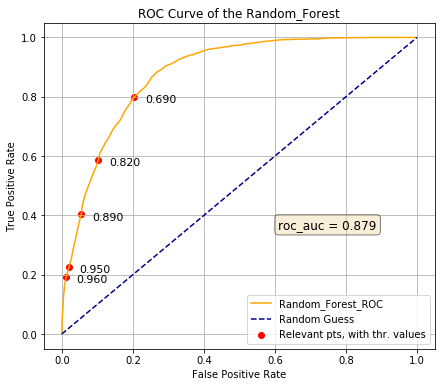

In [184]:
arf_rocan = ROC_Analysis(name="Random_Forest", true_labels=Y_test_noalpha, predictions=apred_randomforest)
arf_rocan.Plot_ROC_Curve()
print('Accuracy:  %.3f' % arandom_forest.score(X_test_noalpha, Y_test_noalpha))
print(arf_rocan.Display_Results())

And this result, as expected, is the worse one obtained.

## Multivariate analysis with the dataset obtained from PCA and T-SNE

To check whether the dataset obtained via the dimensionality reduction techniques used (pca and t-sne) can be used to perform an efficient multivariate analysis, the machine learning architectures implemented above are retrained using such reduced dataset. The goal is to compare the classification performances with the ones obtained with the original dataset.

In [168]:
import time
def Random_Forest(RF_results,dataset):
    n_features=len(dataset.columns)-1
    X = np.array(dataset.iloc[:,:n_features])
    Y = np.array(dataset.iloc[:,n_features])
    X_train, Y_train, X_test, Y_test = transform_split(X,Y)
    
    #define and train model1: random forest
    random_forest=best_RF.model
    start=time.time()
    random_forest.fit(X_train, Y_train)
    end=time.time()

    # save predicted probabilities
    pred_randomforest = random_forest.predict_proba(X_test)[:, 1]   #we keep the probs for the positive class only
     
    Roc_AUC = roc_auc_score(Y_test, pred_randomforest)
    rf_rocan = ROC_Analysis(name="Random_Forest "+str(dataset.name), true_labels=Y_test, predictions=pred_randomforest)

    accuracy=random_forest.score(X_test,Y_test)
                                                                 
    log = pd.DataFrame({
             'Data': [dataset.name],
             'Accuracy': [accuracy],
             'Roc_AUC':[Roc_AUC],
             'CPU Time':[end-start],
            })
    RF_results = RF_results.append(log)
    return(RF_results,rf_rocan)

In [172]:
def MLP(NN_results, params, dataset):
    n_features=len(dataset.columns)-1
    X = np.array(dataset.iloc[:,:n_features])
    Y = np.array(dataset.iloc[:,n_features])
    X_train, Y_train, X_test, Y_test = transform_split(X,Y)
    
    #mlp = create_MLP(**params)
    mlp = best_MLP.model
    start=time.time()
    mlp.fit(X_train, Y_train)
    end=time.time()
    pred = mlp.predict_proba(X_test)[:, 1] 
    mlp_rocan = ROC_Analysis(name='MLP '+str(dataset.name), true_labels=Y_test, predictions=pred, model=mlp)
    #mlp_rocan.Plot_ROC_Curve()

    accuracy = mlp.score(X_test,Y_test)
    Roc_AUC = roc_auc_score(Y_test, pred)
    
    log = pd.DataFrame({
             'Data': [dataset.name],
             'Accuracy': [accuracy],
             'Roc_AUC':[Roc_AUC],
             'CPU Time':[end-start],
            })
    NN_results = NN_results.append(log)
    return(NN_results, mlp_rocan)

In [191]:
#name dataset used for performances comparisons
df_noclass=df.drop(['class','Scaled_Length','Scaled_Width'],axis=1)
df_noclass.name = 'Original data'
df_tsne2.name='2D t-SNE'
df_tsne3.name='3D t-SNE'
df_3.name='3D PCA'
df_6.name='6D PCA'

datasets=[df_noclass,df_tsne2, df_tsne3, df_3, df_6]

### Random Forest

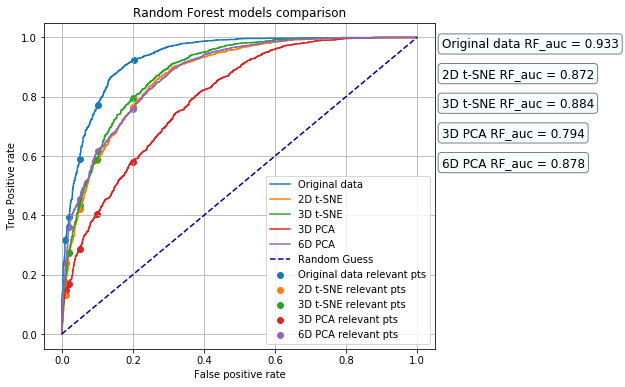

In [171]:
RF_results = pd.DataFrame(columns=['Data','Accuracy','Roc_AUC','CPU Time'])
fig=plt.figure(figsize=(7,6))
idx=0
for data in datasets:
    RF_results, rf_rocan = Random_Forest(RF_results, data)
    rf_rocan.Compute_ROC_Curve()
    #plot
    plt.plot(rf_rocan.fpr,  rf_rocan.tpr,  label=data.name)

    cl_fpr, cl_tpr, cl_th = rf_rocan.Find_Closest_Parameters()
    plt.scatter(cl_fpr, cl_tpr, label=data.name+" relevant pts")
    props = dict(boxstyle="round", facecolor="azure", alpha=0.5)
    txt_roc_auc = data.name+" RF_auc = %.3f" % rf_rocan.AUC_score
    plt.text(1.07, 1-0.1*idx, txt_roc_auc, fontsize=12, verticalalignment='top', bbox=props)
    idx+=1
plt.plot([0, 1], [0, 1], color="darkblue", linestyle='--', label="Random Guess")
plt.title('Random Forest models comparison')
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.grid()
plt.legend()
plt.show()

### Neural Network


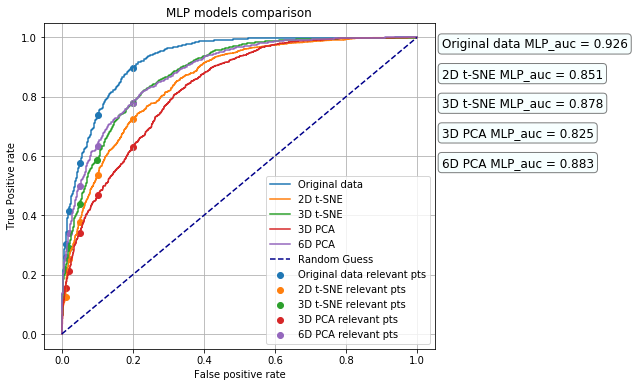

In [179]:
NN_results = pd.DataFrame(columns=['Data','Accuracy','Roc_AUC','CPU Time'])
fig = plt.figure(figsize=(7,6))
idx = 0
for data in datasets:
    NN_results, mlp_rocan = MLP(NN_results, params, data)
    
    mlp_rocan.Compute_ROC_Curve()
    #plot
    plt.plot(mlp_rocan.fpr,  mlp_rocan.tpr,  label=data.name)

    cl_fpr, cl_tpr, cl_th = mlp_rocan.Find_Closest_Parameters()
    plt.scatter(cl_fpr, cl_tpr, label=data.name+" relevant pts")
    props = dict(boxstyle="round", facecolor="azure", alpha=0.5)
    txt_roc_auc = data.name+" MLP_auc = %.3f" % mlp_rocan.AUC_score
    plt.text(1.07, 1-0.1*idx, txt_roc_auc, fontsize=12, verticalalignment='top', bbox=props)
    idx+=1
plt.plot([0, 1], [0, 1], color="darkblue", linestyle='--', label="Random Guess")
plt.title('MLP models comparison')
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.grid()
plt.legend()
plt.show()

In [188]:
print('\nRandom Forest Results:\n\n',RF_results.to_string(index=False))
print('\n\nMLP Results:\n\n',NN_results.to_string(index=False))


Random Forest Results:

           Data  Accuracy   Roc_AUC  CPU Time
 Original data  0.875657  0.933188  9.269289
      2D t-SNE  0.823344  0.872363  2.986666
      3D t-SNE  0.829127  0.883757  2.766164
        3D PCA  0.755521  0.794277  3.081184
        6D PCA  0.820978  0.878328  5.242657


MLP Results:

           Data  Accuracy   Roc_AUC   CPU Time
 Original data  0.871714  0.926071  62.357127
      2D t-SNE  0.803365  0.850927  49.865144
      3D t-SNE  0.823607  0.878266  97.437315
        3D PCA  0.786803  0.824951  25.747048
        6D PCA  0.813617  0.882939  87.993776


As expected, the lower the dimensionality, the lower the accuracy. However, it is interisting to note how the three dimensional t-SNE provided similar results to the 6-dim PCA. The drawback of the former technique is that it is more computational expensive, as its complexity is $\mathcal{O}(NlogN)$, compared to the $\mathcal{O}(min(p^3,n^3))$ of the PCA.<br>
These results finally confirm how, in general, the random forest performs better thant the neural network, both in terms of accuracy and computational time.

## Conclusions
- The study of the **correlations** leads to interesting conclusions about parameter dependencies
- MSE and MLE have an interesting behaviour at different fSize (light) levels. 
- Both a Random Forest and a Multilayer perceptron can fulfill the classification task, with the former that seems more stable.
- Filtering the data by fSize leads to excellent results, dropping fAlpha leads to bad ones.
- Dimensionality reduction may lead to a less time consuming analysis, but leads to a worse performance.